In [174]:
import TextualData.TextualData
import LSTM.lstm as lstm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
from torch.autograd import Variable
import utils
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
reload(utils)

<module 'utils' from 'utils.pyc'>

In [34]:
hidden_size = 256
batch_size = 50
string_len = 50
valid_batches = 200
n_layers = 2
starting_lr = .025
lr_decay_factor = 2.
pos = 1
#Train the network to predict the charachter appearing after stride - Leave = 1
stride = 1
gpu = False

In [35]:
reload(TextualData.TextualData)
text = TextualData.TextualData.TextualData(path='data/full_shak_eng.txt', lower=True)

In [36]:
print 'Computing POS...'
text.compute_pos()
print 'POS computed'
print 'alpha len', text.alpha_len, 'pos len', text.pos_len, 'product', text.alpha_len*text.pos_len

Computing POS...
Created POS data. Train_pos len: 1288818 Valid_pos len: 429606
POS computed
alpha len 53 pos len 16 product 848


In [37]:
if pos == 1:
    rnn = lstm.LSTMmodel(hidden_s=hidden_size, input_s=text.alpha_len*text.pos_len, n_layers=n_layers, gpu=gpu)
else:
    rnn = lstm.LSTMmodel(hidden_s=hidden_size, input_s=text.alpha_len, n_layers=n_layers, gpu=gpu)

rnn.load_state_dict(torch.load('models/LSTM_nlay_2_hidsize_256_pos_1_itr_1000000_loss_1.66.md'))

In [145]:
distribs2=[]
for my_len in range(2,10):
    right_pos=np.zeros(text.alpha_len)
    for rep in range(1000):
        bc=text.get_test_batch(string_len=my_len,batch_size=1,
                                start=np.random.randint(len(text.test_text)-my_len), 
                                pos=pos)
        tbatch=text.batch_to_text(bc)
        posbatch=text.batch_to_pos(bc)
        probs=rnn(bc[0][0])[-1].data.numpy()
        next_ix=bc[0][-1][-1].data[0]
        prob_by_char=np.array([sum(np.exp(fixed_char)) for fixed_char in np.transpose(probs.reshape(-1,text.alpha_len))])
        trials = np.argsort(np.argsort(-1*prob_by_char))[next_ix%text.alpha_len]
        right_pos[trials]+=1
        #print trials, text.alphabet[next_ix%text.alpha_len], 
        #print text.alphabet[int(np.argsort(-1*prob_by_char)[0])]
        #print '-'*6
    right_pos=right_pos/sum(right_pos)
    lowerb=sum((i+1)*(right_pos[i]-right_pos[i+1])*np.log2(i+1) for i in range(len(right_pos)-1))
    distribs.append(right_pos)
    print my_len,lowerb

2 3.5640777795
3 2.55087808474
4 2.08009809231
5 1.66544910367
6 1.6340525616
7 1.57615743446
8 1.46843901415
9 1.49062300372


In [147]:
[sum([i*d[i] for i in range(len(d))]) for d in distribs]

[8.6760000000000019,
 2.3340000000000005,
 2.2989999999999995,
 2.472,
 2.4020000000000001,
 2.3819999999999997,
 2.1670000000000003,
 2.0989999999999998,
 2.1370000000000005,
 2.1430000000000002,
 7.984,
 4.6740000000000013,
 3.4920000000000004,
 2.5570000000000004,
 2.5250000000000004,
 2.4449999999999998,
 2.1230000000000002,
 2.4120000000000008]

In [141]:
reload(utils)
test_b = text.get_test_batch(120, 1, 0, 1, 1)
inp = test_b[0][0]
new_text, new_pos = utils.generate_many_pos_while(rnn, text, input_tensor=inp, pos_type = 1, 
                                             verbose=False, gen_len=2, temp=.55)
print '/\\' * 20
print ''.join(new_text)
print '/\\' * 20

TypeError: generate_many_pos_while() takes at least 6 arguments (7 given)

In [32]:
temp = []
for ix, c in enumerate(new_text):
    if c != ' ':
        temp.append(c)
    else: 
        print ''.join(temp), new_pos[ix]

        temp = []

ather NOUN
wore VERB
it, PUNCT
and CCONJ
your ADJ
father NOUN
endured VERB
it. PUNCT
the DET
horn, PUNCT
the DET
horn, PUNCT
the DET
lustful ADJ
horn NOUN
is VERB
not ADV
to PART
be VERB
laughed VERB
at ADP
or CCONJ
scorned. PUNCT

###fliet ADJ
mascemen NOUN
and CCONJ
only ADV
for ADP
me. PUNCT

###macture
who NOUN
will VERB
be VERB
have VERB
will VERB
do VERB
you PRON
leave VERB
him PRON
to PART
see VERB
the DET
man NOUN
of ADP
the DET
day NOUN
of ADP
offers NOUN
has VERB
my ADJ
lath NOUN
or CCONJ
the DET
greater NOUN
to ADP


In [153]:
sample_pos = text.full_pos[3200:3400]
sample_text = text.full_text[3200:3400]
tks = []
tmp = []
for ix, p in enumerate(sample_pos):
    if p == sample_pos[max(ix-1, 0)]:
        tmp.append(ix)
    else:
        tks.append(tmp)
        tmp = [ix]
ok_tks = [tk for tk in tks[20:] if not(sample_pos[tk[0]] in [3,8])]
np.random.shuffle(ok_tks)
print ''.join([sample_text[p] for p in ok_tks[0]])
print [text.ix_to_pos[sample_pos[p]] for p in ok_tks[0]]
new_text, new_pos = utils.generate_many_pos_while(rnn, text, 
                                                  text.string_to_tensor_pos(sample_text[:ok_tks[0][0]], 
                                                                            sample_pos[:ok_tks[0][0]]
                                                                           ).squeeze(), 
                                                  pos_type = sample_pos[ok_tks[0][0]], 
                                                  follow_text = sample_text[ok_tks[0][-1]+1:], 
                                                  follow_pos = sample_pos[ok_tks[0][-1]+1:], 
                                                  temp = .95, gen_len=30)
print '/\\' * 20
print ''.join(sample_text)
print '/\\' * 20
print '/\\' * 20
print ''.join(new_text), '*'*4, sample_text[ok_tks[0][-1]+1:]
print '/\\' * 20

too seriously
[u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV', u'ADV']
[1.9280306100845337, 1.7756609916687012, 1.942461609840393, 1.868754267692566, 1.891822099685669, 1.8797365427017212, 1.6931672096252441, 1.8532440662384033, 1.92258620262146, 1.8858128786087036, 1.8403526544570923, 1.646579623222351, 1.8416523933410645, 1.8358017206192017, 1.9378281831741333, 1.8698092699050903, 1.8223106861114502, 2.1560466289520264, 1.9318828582763672, 1.8234511613845825, 1.9802899360656738, 1.8920412063598633, 1.8598644733428955, 1.9601415395736694, 2.0839359760284424, 1.7928606271743774, 1.9083248376846313, 1.8305580615997314, 1.9485087394714355, 1.8641397953033447]
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
're meeting for dinner tonight. 
###bassanio
don't worry, i'll be there. 
###gratiano
you don't look well, antonio. you're taking things too seriously. people with too much invested in the world alway
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
/\/

In [225]:
nlp = spacy.load('en_core_web_lg')

In [226]:
doc=nlp(u'The cat is on the table.')

In [227]:
mt=[[tk1.similarity(tk) for tk in doc] for tk1 in doc]

In [232]:
[doc[2].similarity(w) for w in doc.vocab[:100]]

TypeError: an integer is required

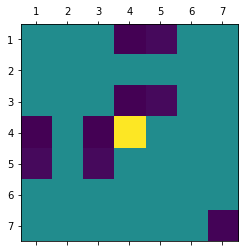

In [214]:
fig = plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(mt)
ax.set_xticklabels(range(8))
ax.set_yticklabels(range(8))
plt.show()

In [212]:
for d in doc:
    print d
    print '-'*10

The
----------
cat
----------
is
----------
on
----------
the
----------
table
----------
.
----------


In [230]:
def most_similar(word):
     by_similarity = sorted(word.vocab, key=lambda w: word.similarity(w), reverse=False)
     return [w.orth_ for w in by_similarity[:10]]
 
most_similar(nlp.vocab[u'dog'])

[u'Anf',
 u'ansd',
 u'REFERED',
 u'\u2014',
 u'a/k/a',
 u'Withe',
 u'withe',
 u'COINCIDENTALLY',
 u'Coincidentally',
 u'aformentioned']